Реализация равномерной схемы крест в лагранжевых координатах

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def z_to_t(z):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    return (2/(3*np.sqrt(Omega_L)) * 1/(h*100*1e5/(R*1e6))
           *np.arcsinh(np.sqrt(Omega_L/(Omega_M*(1 + z)**3)))*3.17*1e-14)

def courant(dt,r,rho,P):
    gamma = 5/3
    c = np.min(np.sqrt(gamma*P[-1,:]/rho[-1,:]))
    dt_new = 0.1*np.min((r[-1,1:]-r[-1,:-1])/c)
    return dt_new*(dt>dt_new) + dt*(dt<dt_new)

In [48]:
r[800,:]

array([3.91299096e+20, 2.06735641e+21, 2.76600932e+21, 3.24711272e+21,
       3.62402073e+21, 3.93853134e+21, 4.21099309e+21, 4.45294728e+21,
       4.67161712e+21, 4.87184687e+21, 5.05705645e+21, 5.22975789e+21,
       5.39185556e+21, 5.54483076e+21, 5.68986065e+21, 5.82789768e+21,
       5.95972451e+21, 6.08599288e+21, 6.20725188e+21, 6.32396892e+21,
       6.43654548e+21, 6.54532925e+21, 6.65062355e+21, 6.75269475e+21,
       6.85177814e+21, 6.94808275e+21, 7.04179520e+21, 7.13308285e+21,
       7.22209643e+21, 7.30897227e+21, 7.39383407e+21, 7.47679448e+21,
       7.55795640e+21, 7.63741413e+21, 7.71525429e+21, 7.79155668e+21,
       7.86639499e+21, 7.93983741e+21, 8.01194721e+21, 8.08278318e+21,
       8.15240008e+21, 8.22084899e+21, 8.28817767e+21, 8.35443081e+21,
       8.41965034e+21, 8.48387562e+21, 8.54714367e+21, 8.60948936e+21,
       8.67094556e+21, 8.73154332e+21, 8.79131198e+21, 8.85027931e+21,
       8.90847164e+21, 8.96591392e+21, 9.02262985e+21, 9.07864195e+21,
      

In [16]:
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]
M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e6*M_sun
R = 3.0856776*1e18 # [cm] 1pc
kB = 1.38*1e-16 # [эрг * К^-1]
c = 3.*1e10 # [sm/s]
h = 0.674

T_s_Myr = 3.17*1e-14 #перевод секунд в Myr
M_min = 1e6*M_sun
length = 100
M = np.linspace(M_min,100*M_min,length)
dm = M[1] - M[0]

T_0 = 2.726 # [K] современная температура фотонов
a1 = 1/119
a2 = 1/115

In [17]:
rho = np.zeros((2,length))
r = np.zeros((2,length))
V = np.zeros((2,length))
T = np.zeros((2,length))
e = np.zeros((2,length))
dPhi_dr = np.zeros((2,length))
P = np.zeros((2,length))

начальные данные

In [18]:
z_in = 100
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)

rho[0,:] = H**2/(8/3*np.pi*G)
r[0,:] = (M/(4/3*np.pi*rho[0,:]))**(1/3)
V[0,:] = H*r[0,:]
T[0,:] = T_0 * (1+z_in) * (1 + a1**(-1)*(1+z_in)**(-1)/(1+a2**(3/2)*(1+z_in)**(3/2)))**(-1)
e[0,:] = 3/2*kB*T[0,:]
P[0,:] = 2/3*rho[0,:]*e[0,:]

dPhi_dr[0,:] = G*M/r[0,:]**2 + G*M_pbh/r[0,:]**2

t = t_in
t_vector = t_in
dt = t_in/100
sim_time = 0

i = 0

while t<t_in*10:
    V[i+1,:-1] = V[i,:-1] - dt*dPhi_dr[i,:-1] + dt/dm*(P[i,:-1]-P[i,1:])*r[i,:-1]**2
    r[i+1,:-1] = r[i,:-1] + dt*V[i+1,:-1]

    # Граничное условие на бесконечности
    V[i+1,-1] = V[i,-1] - dt*dPhi_dr[i,-1]
    r[i+1,-1] = r[i,-1] + dt*V[i+1,-1]

    rho[i+1,:-1] = 3*dm/(r[i+1,1:]**3 - r[i+1,:-1]**3)/(4*np.pi)
    rho[i+1,-1] = rho[i+1,-2]
    e[i+1,:] = (e[i,:]+1/2*P[i,:]*(1/rho[i,:]-1/rho[i+1,:]))/(1-1/3*rho[i+1,:]*(1/rho[i,:]-1/rho[i+1,:]))
    T[i+1,:] = 2/3*e[i+1,:]/kB
    P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]


    # Переход на следующий слой
    dPhi_dr[i+1,:] = G*M/r[i+1,:]**2 + G*M_pbh/r[i+1,:]**2

    dt_new = courant(dt,r,rho,P)
    if dt_new<dt:
        dt = dt_new
        print(i)
        continue

    i+=1
    t += dt
    H_new = 2/(3*t)

    t_vector = np.append(t_vector,t)
    H = np.append(H,H_new)
    V = np.vstack([V,np.zeros(length)])
    r = np.vstack([r,np.zeros(length)])
    rho = np.vstack([rho,np.zeros(length)])
    e = np.vstack([e,np.zeros(length)])
    T = np.vstack([T,np.zeros(length)])
    P = np.vstack([P,np.zeros(length)])
    dPhi_dr = np.vstack([dPhi_dr,np.zeros(length)])

Отрисовка

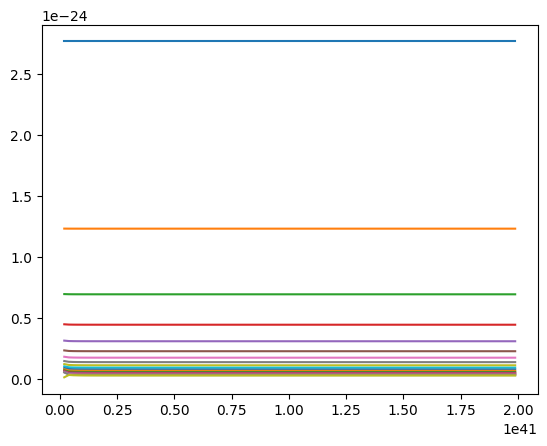

In [28]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, rho.shape[0]-1, draw_time_step):
    ax.plot(M[:], rho[i, :])
plt.show()

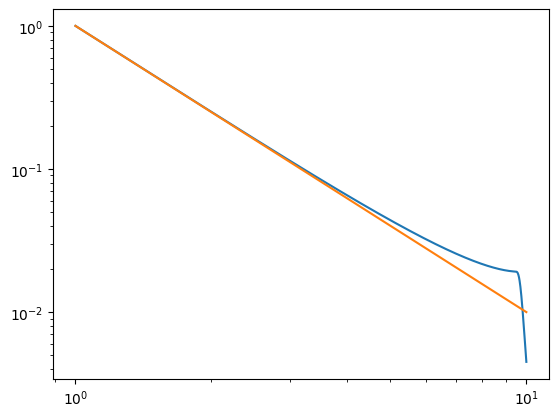

In [65]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], rho[:-1, 0]/rho[0, 0])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-2)

In [73]:
P[-2,:]

array([7.77134892e-42, 3.79908846e-41, 3.34530390e-41, 3.19616919e-41,
       3.12752106e-41, 3.09000319e-41, 3.06718931e-41, 3.05225756e-41,
       3.04194159e-41, 3.03451204e-41, 3.02898172e-41, 3.02475295e-41,
       3.02144639e-41, 3.01881168e-41, 3.01667814e-41, 3.01492610e-41,
       3.01346962e-41, 3.01224572e-41, 3.01120733e-41, 3.01031874e-41,
       3.00955244e-41, 3.00888696e-41, 3.00830535e-41, 3.00779408e-41,
       3.00734223e-41, 3.00694094e-41, 3.00658293e-41, 3.00626219e-41,
       3.00597373e-41, 3.00571334e-41, 3.00547750e-41, 3.00526322e-41,
       3.00506795e-41, 3.00488950e-41, 3.00472599e-41, 3.00457580e-41,
       3.00443752e-41, 3.00430992e-41, 3.00419194e-41, 3.00408263e-41,
       3.00398115e-41, 3.00388678e-41, 3.00379887e-41, 3.00371684e-41,
       3.00364019e-41, 3.00356844e-41, 3.00350119e-41, 3.00343807e-41,
       3.00337876e-41, 3.00332294e-41, 3.00327035e-41, 3.00322075e-41,
       3.00317391e-41, 3.00312964e-41, 3.00308774e-41, 3.00304806e-41,
      

In [68]:
rho[-1,0]

0.0

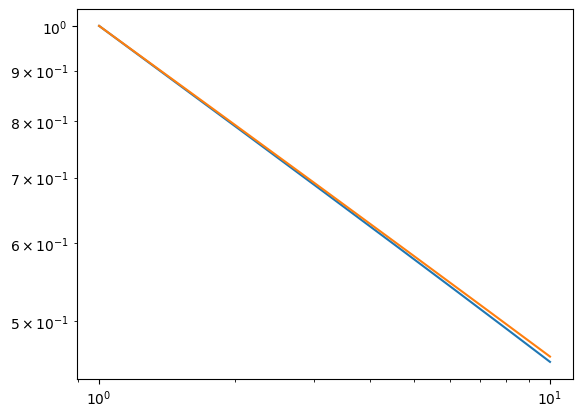

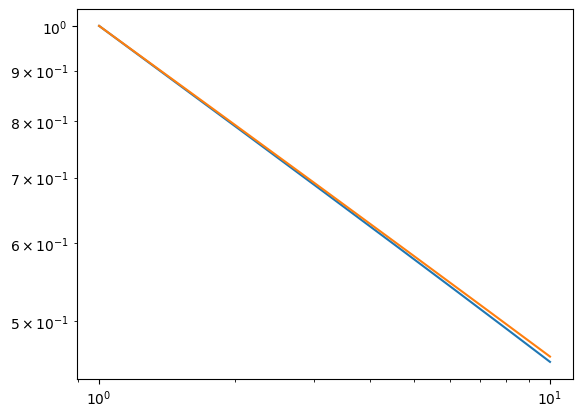

In [23]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, -1]/V[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],H*r[:-1,-1]/V[0,-1])

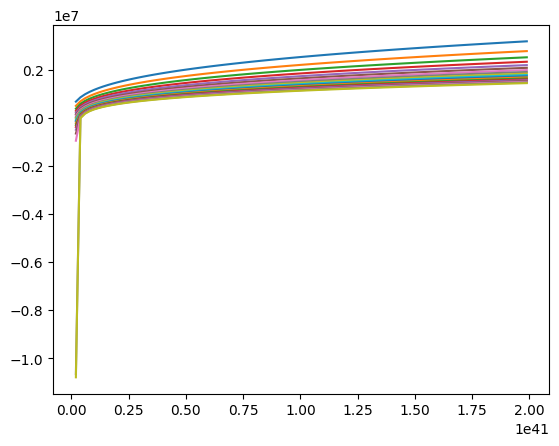

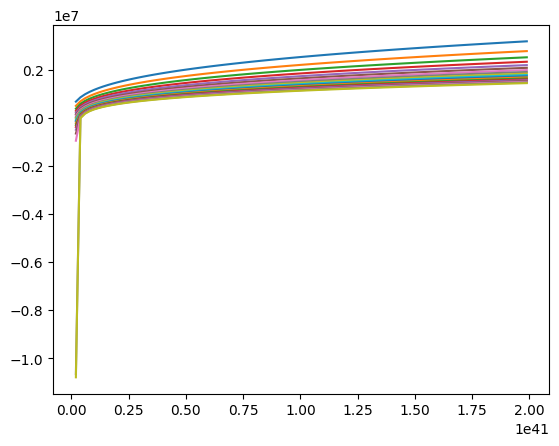

In [24]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, V.shape[0]-1, draw_time_step):
    ax.plot(M[:], V[i+1, :])
plt.show()

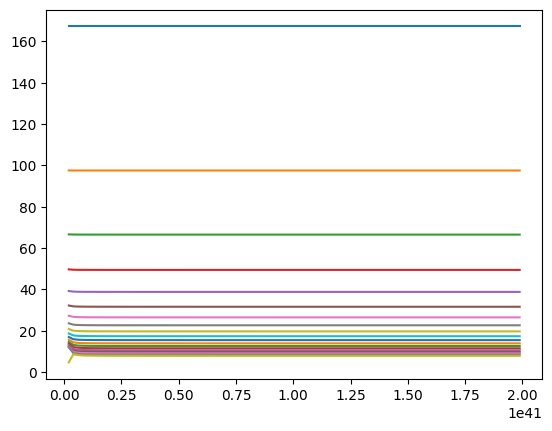

In [49]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, T.shape[0]-1, draw_time_step):
    ax.plot(M[:], T[i, :])
plt.show()

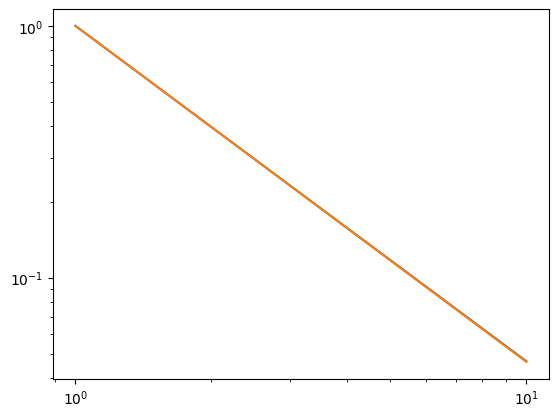

In [27]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], T[:-1, -1]/T[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-(4/3))

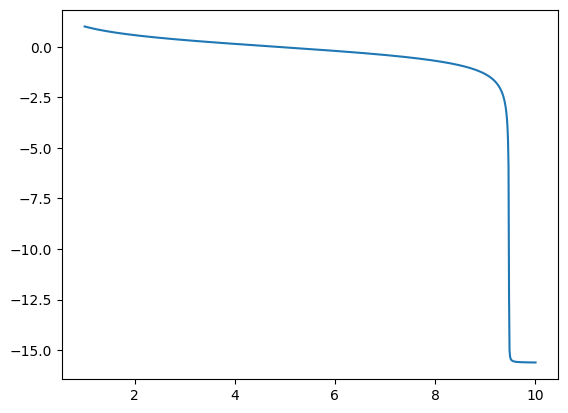

In [75]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, 0]/V[0, 0])